In [1]:
import numpy as np
import tensorflow as tf
import random
import gzip
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

validation_datasize = 5000
training_datasize = 55000

def fill_background(img, direction, pos):
    if direction == "updown":
        img[pos, :] = np.zeros(28)  
    else:
        img[:, pos] = np.zeros(28)
    return img
    
def expand_img_with_displacement(img, label):
    disp_imgs = [ fill_background(np.roll(img.reshape(-1,28), d, axis), direction, pos)
                                        for d, axis, direction, pos in [ 
                                                (1,  0, "updown", 0),
                                                (-1, 0, "updown", 27),
                                                (1,  1, "leftright", 0),
                                                (-1, 1, "leftright", 27)] ] 
    disp_pairs = [(np.reshape(img, 784), label) for img in disp_imgs]
    return [(img, label)] + disp_pairs

def expand_imgs_with_displacement(imgs, labels):
    return [pair for x,y in zip(imgs, labels) for pair in expand_img_with_displacement(x, y)]

def expand_validation_dataset(datasize = 5000):
    with tf.Session() as sess:   
        imgs, labels = mnist.validation.next_batch(datasize)
        return expand_imgs_with_displacement(imgs, labels)

def expand_training_dataset(datasize = 55000):
    with tf.Session() as sess:   
        imgs, labels = mnist.train.next_batch(datasize)
        return expand_imgs_with_displacement(imgs, labels)


expanded_total_pairs = expand_validation_dataset(validation_datasize) + expand_training_dataset(training_datasize)    
random.shuffle(expanded_total_pairs)
expanded_data, expanded_labels = [list(d) for d in zip(*expanded_total_pairs)]
new_imgs = np.array(expanded_data)
new_labels = np.array(expanded_labels)
with gzip.open('MNIST_data_expand/train-images-idx3-ubyte.gz', 'wb') as f:
    # 4*4 = 16 bytes = magic_number (2051) + num_images + rows (28) + cols (28)
    dt = np.dtype(np.uint32).newbyteorder('>')    
    hdrs = np.array([2051, len(new_imgs), 28, 28], dtype=dt)
    f.write(hdrs) 
    new_imgs = np.multiply(new_imgs, 255).astype(np.uint8)
    f.write(new_imgs)
    
with gzip.open('MNIST_data_expand/train-labels-idx1-ubyte.gz', 'wb') as f:
    # 4*2 = 8 bytes = magic_number (2049) + num_items
    dt = np.dtype(np.uint32).newbyteorder('>')    
    hdrs = np.array([2049, len(new_labels)], dtype=dt)
    f.write(hdrs)                
    f.write(new_labels)
    
print('Expand dataset to {} records'.format(len(new_labels)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Expand dataset to 300000 records


Extracting MNIST_data_expand/train-images-idx3-ubyte.gz
Extracting MNIST_data_expand/train-labels-idx1-ubyte.gz
Extracting MNIST_data_expand/t10k-images-idx3-ubyte.gz
Extracting MNIST_data_expand/t10k-labels-idx1-ubyte.gz
total training datasize = 295000, validation datasize = 5000


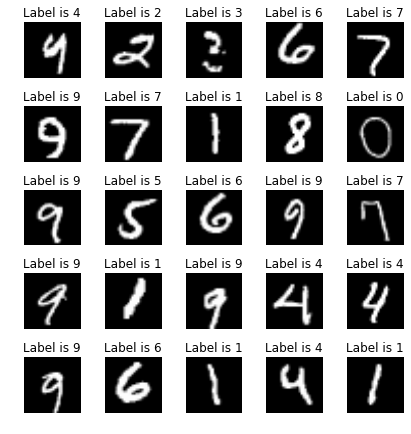

In [4]:
## Examine Expanded Dataset 

# Import MINST data
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data_expand', one_hot=False)

print('total training datasize = {}, validation datasize = {}'.format(mnist.train.num_examples, mnist.validation.num_examples))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

with tf.Session() as sess:
    img, lbl = mnist.train.next_batch(25)
    img = img.reshape((-1, 28, 28))

fig = plt.figure(figsize=(7,7))
fig = plt.figure(1)  
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)
gs = gridspec.GridSpec(5, 5)
for k in ((i,j) for i in range(5) for j in range(5)):
    ax = plt.subplot(gs[k[0],k[1]])
    ax.set_title('Label is {}'.format(lbl[k[0]*5 + k[1]])) 
    ax.axis('off')
    ax.imshow(img[k[0]*5 + k[1]], cmap='gray')
    fig.add_subplot(ax) 